In [111]:
import time
import numpy as np
import os
import random
import math
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scipy.misc as misc
import copy
%matplotlib inline

In [2]:
data_directory = "/data/"
training_filename = "training.csv"
batch_size = 64

# Images are 96 x 96 grayscale with 15 features using (x, y) coordinates
image_size = 96
num_channels = 1 # grayscale
num_classes = 30

# Distort Input
flip_images = False
brighten_images = False
noisy_images = False
rotate_images = False

In [87]:
def rotatePoint(centerPoint,point,angle):
    
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

In [3]:
def _slicer(array, slice_amount):
    return array[slice_amount]

In [4]:
def _shuffle_arrays(arrays, random):
    random_state = random.get_state()
    for array in arrays:
        random.set_state(random_state)
        random.shuffle(array)

In [5]:
class MiniBatchIterator(object):
    def __init__(self, batch_size, shuffle=False, seed=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, value, label=None):
        if self.shuffle:
            _shuffle_arrays([value, label] if label is not None else [value], self.random)
        self.value, self.label = value, label
        return self

    def __iter__(self):
        for i in range((len(self.value) + self.batch_size - 1) // self.batch_size):
            slice_amount = slice(i * self.batch_size, (i + 1) * self.batch_size)
            value_slice = _slicer(self.value, slice_amount)
            if self.label is not None:
                label_slice = _slicer(self.label, slice_amount)
            else:
                label_slice = None
            yield self.transform(value_slice, label_slice)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state

In [135]:
class AugBatchIterator(MiniBatchIterator):
    
    def __init__(self, batch_size, shuffle=False, seed=1, add_flips=False, add_noise=False, add_bright=False, add_rotate=False):
        super(AugBatchIterator, self).__init__(batch_size, shuffle=False, seed=1)
        self.add_flips = add_flips
        self.add_noise = add_noise
        self.add_bright = add_bright
        self.add_rotate = add_rotate
        self.flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    def transform(self, x_data, y_data):
        x_data, y_data = super(AugBatchIterator, self).transform(x_data, y_data)

        x_temp = copy.deepcopy(x_data)
        y_temp = copy.deepcopy(y_data)
        
        #Flip
        bs = x_temp.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        x_temp[indices] = x_temp[indices, :, ::-1, :]

        if self.add_flips:
            # 50% chance to flip
            data_shape = x_temp.shape[0]
            indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
            x_temp[indices] = x_temp[indices, :, ::-1]

        if y_temp is not None:
            y_temp[indices, ::2] = y_temp[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                y_temp[indices, a], y_temp[indices, b] = (y_temp[indices, b], y_temp[indices, a])
                
        if bright:
            data_shape = x_temp.shape[0]
            indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
            #print(x_temp[0,0])
            x_temp[indices] = x_temp[indices]*random.uniform(0.55, 1.55)

        
        if noise:
            data_shape = x_temp.shape[0]
            indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
            x_temp[indices] = x_temp[indices] + np.random.normal(-0.3, 0.3) * x_temp[indices].std() * np.random.random(x_temp[indices].shape)


        if rotate:
            for i in range(0, len(x_temp)):
                val = random.uniform(0, 1)
                if val > .5:
                    angle = random.uniform(0, 0) 
                    x_temp[i] = np.reshape(misc.imrotate(np.reshape(x_temp[i], [image_size, image_size]), -angle), [image_size, image_size, 1])
                    for j in range(0, 30, 2):
                        y_temp[i, j], y_temp[i, j+1] = rotatePoint((0, 0), (y_temp[i, j], y_temp[i, j+1]), angle)


        return x_temp, y_temp

In [7]:
def loadData(filename):
    
    df = pd.read_csv(filename)

    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    df = df.dropna()

    values = np.vstack(df['Image'].values) / 255.
    values = values.astype(np.float32)

    labels = df[df.columns[:-1]].values
    labels = (labels - 48) / 48  
    values, labels = shuffle(values, labels, random_state=3)  
    labels = labels.astype(np.float32)

    return values, labels

In [114]:
image_values, image_labels = loadData(os.getcwd() + data_directory + training_filename)
image_values = np.reshape(image_values, [-1, image_size, image_size, 1])

In [9]:
def splitData(data, data2, percentage):
    data11 = data[:int(len(data)*percentage)]
    data12 = data[int(len(data)*percentage):]
    
    data21 = data2[:int(len(data2)*percentage)]
    data22 = data2[int(len(data2)*percentage):]
    
    return data11, data12, data21, data22

## Train/Validation/Test Split

In [116]:
train_images, valid_images, train_labels, valid_labels = splitData(image_values, image_labels, 0.7)

valid_images, test_images, valid_labels, test_labels = splitData(valid_images, valid_labels, 0.5)

In [11]:
def createConvolutionLayer(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))
    
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    added = tf.nn.bias_add(convolution, biases)
    
    total_parameters = kernel_size*kernel_size*features*depth + depth
    print("Created Convolution Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.relu(added)

In [12]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    total_parameters = x_input.get_shape()[1] * width + width
    
    print("Created Fully Connected Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [13]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLU in graph
    # 
    print("Created RELU Activation Function")
    return tf.nn.relu(x_input)

In [14]:
def createPoolingLayer(x_input, kernel_size):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    
    print("Created Pooling Layer: Downsample:" + str(kernel_size))
    return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size,kernel_size, 1], padding='SAME')

In [15]:
def createSimpleNetwork(model_input):
    with tf.variable_scope('input'):
        input_layer = tf.reshape(model_input, [-1, image_size * image_size])
    with tf.variable_scope('hidden'):
        hidden_fully_connected_layer = createFullyConnectedLayer(input_layer, 100)
    relu_layer = createLinearRectifier(hidden_fully_connected_layer)
    with tf.variable_scope('out'):
        model_output = createFullyConnectedLayer(relu_layer, 30)
        
    print("Simple Network Created")
    return model_output

In [198]:
def createConvNetwork(x_input, is_train):
    # Define convolution layers
    with tf.variable_scope('conv1'):
        convolution_layer1 = createConvolutionLayer(x_input, 3, 1, 32)
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer1 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer1, keep_prob=0.9), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        convolution_layer2 = createConvolutionLayer(pooling_layer1, 2, 32, 64)
        pooling_layer2 = createPoolingLayer(convolution_layer2, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer2 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer2, keep_prob=0.8), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        convolution_layer3 = createConvolutionLayer(pooling_layer2, 2, 64, 128)
        pooling_layer3 = createPoolingLayer(convolution_layer3, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer3 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer3, keep_prob=0.7), lambda: pooling_layer3)
    
    # Flatten output to connect to fully connected layers
    print("fc: input size before flattening: " + str(pooling_layer3.get_shape()))
    pooling_layer3_shape = pooling_layer3.get_shape().as_list()
    pooling_layer3_flattened = tf.reshape(pooling_layer3, [-1, pooling_layer3_shape[1] * pooling_layer3_shape[2] * pooling_layer3_shape[3]])
    
    # Define fully connected layers
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer3_flattened, 500)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        fully_connected_relu1 = tf.cond(is_train, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob=0.5), lambda: fully_connected_relu1)
    with tf.variable_scope('fc2'):
        fully_connected_layer2 = createFullyConnectedLayer(fully_connected_relu1, 500)
        fully_connected_relu2 = createLinearRectifier(fully_connected_layer2)
    with tf.variable_scope('out'):
        output = createFullyConnectedLayer(fully_connected_relu2, num_classes)
        print("out: " + str(output.get_shape()))
    return output

In [17]:
def getPredictions(values, session):
    predictions = []
    batch = MiniBatchIterator(batch_size = 128)
    for batch_values, _ in batch(values):
        prediction_batch = session.run(model_predictions, feed_dict = {model_input : batch_values, model_training : False})
        predictions.extend(prediction_batch)
    return predictions

In [18]:
def getLoss(values, labels, session):
    loss = []
    batch = MiniBatchIterator(batch_size = 128)
    for batch_values, batch_labels in batch(values, labels):
        loss_batch = session.run(model_loss, feed_dict = {model_input : batch_values, model_output : batch_labels, model_training : False})
        loss.append(loss_batch)
    return np.mean(loss)

In [19]:
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [20]:
def saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, name):
    df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})
    writer = pd.ExcelWriter(model_path + name + '.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Sheet1')
    writer.save()

In [172]:
def trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, batch_size, model_name, flip, noise, bright, rotate):
    start = time.time()
    train_loss_list = []
    valid_loss_list = []
    time_list = []
    epoch_list = []
    print("TRAINING: " + model_name)

    with tf.Session(graph = graph) as session:

        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if os.path.exists(model_directory):
            print("Loading model...")
            load_path = saver.restore(session, model_path)

        for epoch in range(num_epochs):
            current_epoch = epoch
            batch = AugBatchIterator(batch_size=batch_size, shuffle=True, add_flips=flip, add_noise=noise, add_bright=bright, add_rotate=rotate)
            for batch_data, batch_labels in batch(train_images, train_labels):
                feed_dict = {model_input: batch_data, model_output: batch_labels, model_training: dropout}
                # train model
                session.run([model_optimizer], feed_dict = feed_dict)

            #Store train and validation losses
            if current_epoch % 10 == 0:
                train_loss = getLoss(train_images, train_labels, session)
                train_loss_list.append(train_loss)
                valid_loss = getLoss(valid_images, valid_labels, session)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)
                print("Epoch[%4d]" % epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate.eval() + "%f" % momentum_rate.eval())

                time_list.append(current_time)
                epoch_list.append(current_epoch)

            if current_epoch % 300 == 0:
                if not os.path.exists(model_directory):
                    os.mkdir(model_directory)
                print("Saving Model...")    
                save_path = saver.save(session, model_path)
            # Evaluate on test dataset.
        test_loss = getLoss(test_images, test_labels, session)
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) #RMSE
        if not os.path.exists(model_directory):
            os.mkdir(model_directory)
        print("Saving Model...")
        save_path = saver.save(session, model_path)
        saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, 'Loss3')

In [200]:
#Model Name
model_name = "ConvNet-Momentum01-DA-DROPOUT-MoInc-LRNDec-largerfc"
model_filename = model_name + ".ckpt"
model_directory = os.getcwd() + "/Models5/" + model_name
model_path = model_directory + "/" + model_filename

graph = tf.Graph()

with graph.as_default():
    
    model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
    model_training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0)
    #Define Parameters
    num_epochs=8000

    learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps=num_epochs, decay_rate=0.03)
    dropout = True

    m_min = 0.9
    m_max = 0.99
    momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
    # get model
    #with tf.variable_scope(model_name):
    #    model_predictions = createSimpleNetwork(model_input)
    with tf.variable_scope(model_name):
        model_predictions = createConvNetwork(model_input, model_training)
    
    model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))
    
    model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
    #model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    #model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss)


conv: input size: (?, 96, 96, 1)
Created Convolution Layer: Input(?, 96, 96, 1) Parameters(320)
Created Pooling Layer: Downsample:2
conv: input size: (?, 48, 48, 32)
Created Convolution Layer: Input(?, 48, 48, 32) Parameters(8256)
Created Pooling Layer: Downsample:2
conv: input size: (?, 24, 24, 64)
Created Convolution Layer: Input(?, 24, 24, 64) Parameters(32896)
Created Pooling Layer: Downsample:2
fc: input size before flattening: (?, 12, 12, 128)
Created Fully Connected Layer: Input(?, 18432) Parameters(9216500)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 500) Parameters(250500)
Created RELU Activation Function
Created Fully Connected Layer: Input(?, 500) Parameters(15030)
out: (?, 30)


In [194]:
momentum_rate

<tf.Tensor 'add:0' shape=() dtype=float64>

In [175]:
flip = True
rotate = False
noise = False
bright = False

trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, 128, model_name, flip, noise, bright, rotate)

TRAINING: ConvNet-Momentum01-DA-DROPOUT-MoInc-LRNDec
Epoch[   0]0: 0: 4 0.019779  0.019882 0.030000 0.900000
Saving Model...
Epoch[  10]0: 0:35 0.006478  0.006702 0.030000 0.900000
Epoch[  20]0: 1: 6 0.005470  0.005656 0.030000 0.900000
Epoch[  30]0: 1:36 0.005094  0.005265 0.030000 0.900000
Epoch[  40]0: 2: 7 0.004961  0.005128 0.030000 0.900000
Epoch[  50]0: 2:38 0.004797  0.004954 0.030000 0.900000
Epoch[  60]0: 3: 8 0.004704  0.004859 0.030000 0.900000
Epoch[  70]0: 3:39 0.004613  0.004759 0.030000 0.900000
Epoch[  80]0: 4: 9 0.004515  0.004650 0.030000 0.900000
Epoch[  90]0: 4:40 0.004472  0.004596 0.030000 0.900000
Epoch[ 100]0: 5:10 0.004446  0.004565 0.030000 0.900000
Epoch[ 110]0: 5:41 0.004416  0.004537 0.030000 0.900000
Epoch[ 120]0: 6:11 0.004414  0.004534 0.030000 0.900000
Epoch[ 130]0: 6:41 0.004410  0.004528 0.030000 0.900000
Epoch[ 140]0: 7:12 0.004400  0.004513 0.030000 0.900000
Epoch[ 150]0: 7:42 0.004403  0.004522 0.030000 0.900000
Epoch[ 160]0: 8:13 0.004396  0.0045

### Cross Validate via KFolds

In [ ]:
kfolds = 5
#kfolds loop
#new name
#train
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(image_values, image_labels):
    parameters

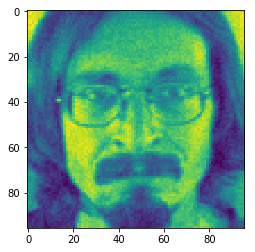

KeyboardInterrupt: 

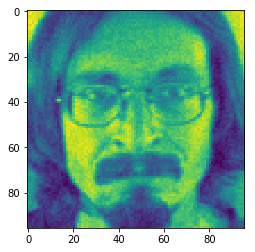

In [145]:
from IPython import display

flip = False
rotate = False
noise = False
bright = False
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    pred = session.run(model_predictions, feed_dict={model_input: test_images, model_training:False})
    
batch = AugBatchIterator(batch_size=batch_size, shuffle=True, add_flips=flip, add_noise=noise, add_bright=bright, add_rotate=rotate)
for batch_data, batch_labels in batch(train_images, train_labels):
    
    plt.imshow(np.resize(batch_data[5], [image_size, image_size]))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

In [139]:
x_temp = copy.deepcopy(valid_images[0])
y_temp = copy.deepcopy(valid_labels[0])
angle = random.uniform(0, 0) 
x_temp = np.reshape(misc.imrotate(np.reshape(x_temp, [image_size, image_size]), -angle), [image_size, image_size, 1])
for j in range(0, 30, 2):
    y_temp[j], y_temp[j+1] = rotatePoint((0, 0), (y_temp[j], y_temp[j+1]), angle)


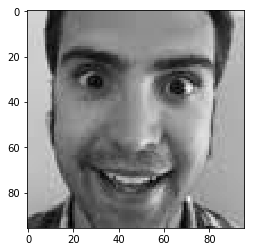

In [176]:
import matplotlib.image as mpimg

new_image = mpimg.imread('jarrett.jpg')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

new_image = rgb2gray(new_image)
plt.imshow(new_image)

new_image = new_image / 255

plt.imshow(new_image, cmap="gray")

In [201]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    pred = session.run(model_predictions, feed_dict={model_input: np.reshape(new_image, [1, 96, 96, 1]), model_training:False})
    #valid_loss = getLoss(valid_images, valid_labels, session)
    #loss = session.run(loss_function, feed_dict={tf_x_batch: x_valid, y_output: y_valid, is_training:False})
    #print(loss)

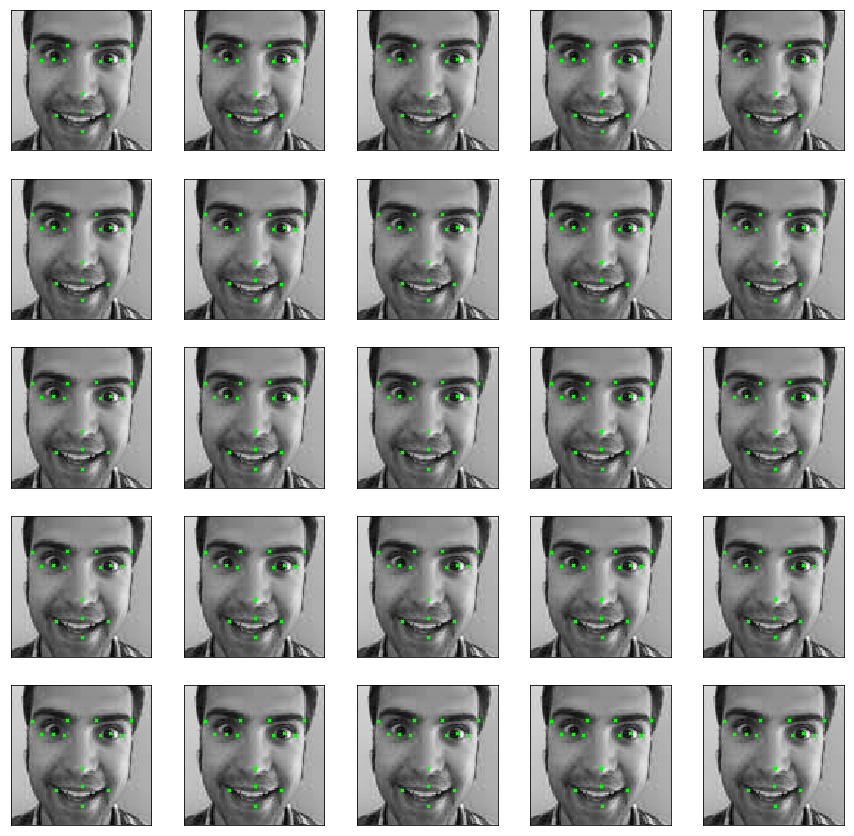

In [202]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = new_image
    img = img.reshape(96, 96)
    #y = y_test[i]
    y2 = pred[0]
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()